# IoT Device Script Test

A complete test of the entire interface with the AWS IoT Hub

In [1]:
# Load libraries

from AWSIoTPythonSDK.MQTTLib import AWSIoTMQTTClient
import sys
import logging
import time
import getopt
import json
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#load in dataset
df = pd.read_csv("../data/movie_ratings_simple.csv")

In [2]:
#Build a random title
titlelist = " ".join(df['title'])
import re
# Use regular expressions to do a find-and-replace
letters_only = re.sub("[^a-zA-Z]",           # The pattern to search for
                      " ",                   # The pattern to replace it with
                      titlelist )  # The text to search

words = [x.lower().strip() for x in letters_only.split(" ")]
words = [x for x in words if x != '']
import nltk
#nltk.download()
from nltk.corpus import stopwords # Import the stop word list
#print(stopwords.words("english") )
stops = set(stopwords.words("english")) 
# 5. Remove stop words
meaningful_words = [w for w in words if not w in stops]   
def getTitle(meaningful_words):
    wordseries=pd.Series(meaningful_words)
    newstring = ' '.join(wordseries.sample(n=np.random.randint(1,5)))
    prefixrand = np.random.randint(0,4)
    if prefixrand == 2:
        newstring = 'the ' + newstring
    elif prefixrand == 3:
        newstring = 'a ' + newstring
    return newstring.title()
#for k in range(15):
#    print(getTitle(meaningful_words))

def on_draw(event):
    """Auto-wraps all text objects in a figure at draw-time"""
    import matplotlib as mpl
    fig = event.canvas.figure

    # Cycle through all artists in all the axes in the figure
    for ax in fig.axes:
        for artist in ax.get_children():
            # If it's a text artist, wrap it...
            if isinstance(artist, mpl.text.Text):
                autowrap_text(artist, event.renderer)

    # Temporarily disconnect any callbacks to the draw event...
    # (To avoid recursion)
    func_handles = fig.canvas.callbacks.callbacks[event.name]
    fig.canvas.callbacks.callbacks[event.name] = {}
    # Re-draw the figure..
    fig.canvas.draw()
    # Reset the draw event callbacks
    fig.canvas.callbacks.callbacks[event.name] = func_handles

def autowrap_text(textobj, renderer):
    """Wraps the given matplotlib text object so that it exceed the boundaries
    of the axis it is plotted in."""
    import textwrap
    # Get the starting position of the text in pixels...
    x0, y0 = textobj.get_transform().transform(textobj.get_position())
    # Get the extents of the current axis in pixels...
    clip = textobj.get_axes().get_window_extent()
    # Set the text to rotate about the left edge (doesn't make sense otherwise)
    textobj.set_rotation_mode('anchor')

    # Get the amount of space in the direction of rotation to the left and 
    # right of x0, y0 (left and right are relative to the rotation, as well)
    rotation = textobj.get_rotation()
    right_space = min_dist_inside((x0, y0), rotation, clip)
    left_space = min_dist_inside((x0, y0), rotation - 180, clip)

    # Use either the left or right distance depending on the horiz alignment.
    alignment = textobj.get_horizontalalignment()
    if alignment is 'left':
        new_width = right_space 
    elif alignment is 'right':
        new_width = left_space
    else:
        new_width = 2 * min(left_space, right_space)

    # Estimate the width of the new size in characters...
    aspect_ratio = 0.5 # This varies with the font!! 
    fontsize = textobj.get_size()
    pixels_per_char = aspect_ratio * renderer.points_to_pixels(fontsize)

    # If wrap_width is < 1, just make it 1 character
    wrap_width = max(1, new_width // pixels_per_char)
    try:
        wrapped_text = textwrap.fill(textobj.get_text(), wrap_width)
    except TypeError:
        # This appears to be a single word
        wrapped_text = textobj.get_text()
    textobj.set_text(wrapped_text)

def min_dist_inside(point, rotation, box):
    """Gets the space in a given direction from "point" to the boundaries of
    "box" (where box is an object with x0, y0, x1, & y1 attributes, point is a
    tuple of x,y, and rotation is the angle in degrees)"""
    from math import sin, cos, radians
    x0, y0 = point
    rotation = radians(rotation)
    distances = []
    threshold = 0.0001 
    if cos(rotation) > threshold: 
        # Intersects the right axis
        distances.append((box.x1 - x0) / cos(rotation))
    if cos(rotation) < -threshold: 
        # Intersects the left axis
        distances.append((box.x0 - x0) / cos(rotation))
    if sin(rotation) > threshold: 
        # Intersects the top axis
        distances.append((box.y1 - y0) / sin(rotation))
    if sin(rotation) < -threshold: 
        # Intersects the bottom axis
        distances.append((box.y0 - y0) / sin(rotation))
    return min(distances)

For testing purposes, I build the array of 36 choices as a new dataframe that I can then plot/work with. I only use directors that have more than 20 films in the database in order to use recognizable names.

The first table is of films that the selected directors have previously made, colored by their ratings.

C:\Anaconda3\lib\site-packages\matplotlib\artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


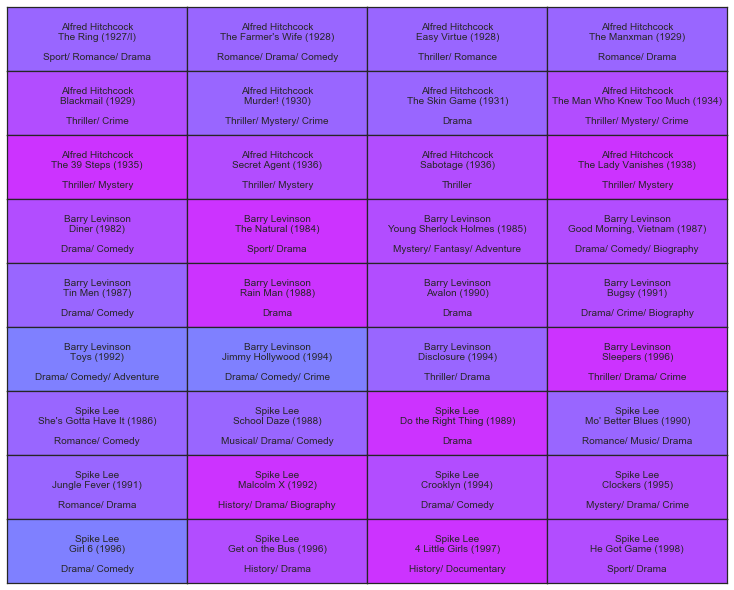

In [12]:
vc=df['Director1'].value_counts()
subdir = vc[vc>20]
#print(len(subdir))
directors = subdir.sample(n=3).index.values
#directors = df['Director1'].sample(n=3).values

years = df['year'].sample(n=3).values

def getGenres(df):
    #Get genre options:
    genrechoices = []
    for k in range(4):
        g1 = df['Genre1'].sample(n=1).values[0]
        g2 = g1
        g3 = g1
        while g2 == g1:
            g2 = df['Genre2'].sample(n=1).values[0]
        if g2 == 'None':
            g3 = 'None'
        else:
            g3 = g1
            g3 = g2
            while g3 == g1 or g3 == g2:
                g3 = df['Genre3'].sample(n=1).values[0]
        genrechoices.append([g1,g2,g3])
    return genrechoices
genrechoices = getGenres(df)

datachoices = pd.DataFrame(columns=['title','Director1','year','Genre1','Genre2','Genre3'])
index = 0
for director in directors:
    for year in years:
        for choice in genrechoices:
            newdata = dict()
            newdata['title'] = getTitle(meaningful_words) + ' ({})'.format(year)
            newdata['Director1'] = [director]
            newdata['year'] = [str(year)]
            newdata['Genre1'] = [choice[0]]
            newdata['Genre2'] =[choice[1]]
            newdata['Genre3'] = [choice[2]]
            new_df = pd.DataFrame.from_dict(newdata)
            datachoices = datachoices.append(new_df, ignore_index=True)
#Get the other movies that these directors have done

comparedf = pd.DataFrame()
for director in directors:
    comparedf = comparedf.append(((df[df['Director1']==director].sort_values(['stars'],ascending=False)).sort_values('year'))[:12][['title','year','Director1','Genre1','Genre2','Genre3','stars']])
comparedf.sort_values(['Director1','year','Genre1','Genre2','Genre3'],inplace=True)
    #comparedf
comparedf.reset_index(inplace=True,drop=True)
sns.set_style("white")
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(9, 4)
loc = 0
plt.figure(figsize=(10, 8))
for k in range(9):
    for j in range(4):
        ax = plt.subplot(gs[k, j])
        ax.text(0,0.8,comparedf['Director1'].ix[loc],ha='center', va='top')
        
        ax.text(0,0,comparedf['title'].ix[loc],horizontalalignment='center',ha='center', va='top')
        ax.text(0,-1.6,"/ ".join([x for x in comparedf[['Genre1','Genre2','Genre3']].ix[loc].values if x != 'None']),horizontalalignment='center', \
                verticalalignment='top')
        
        ax.set_axis_bgcolor(plt.cm.cool(int((comparedf['stars'].ix[loc])*255./10)))
        ax.set_ylim([-3,2])
        ax.set_xlim([-3,3])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        loc += 1
        #plt.axis('off')
plt.gcf().canvas.mpl_connect('draw_event', on_draw)
plt.tight_layout(pad=0)

From this set of directors/year/genres, it looks like the highest rating might be Spike Lee for a 1989 drama. We'll compare that to the predictions made by the machine learning endpoint.

We now create a random set of year/genre combinations for these directors.

C:\Anaconda3\lib\site-packages\matplotlib\artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


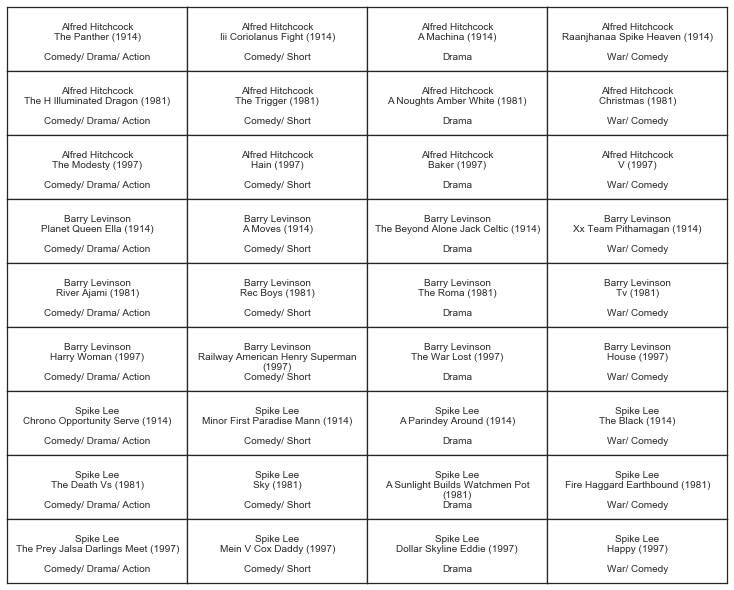

In [13]:
datachoices.sort_values(['Director1','year','Genre1','Genre2','Genre3'],inplace=True)
datachoices.reset_index(drop=True,inplace=True)
sns.set_style("white")
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(9, 4)
loc = 0
plt.figure(figsize=(10, 8))
for k in range(9):
    for j in range(4):
        ax = plt.subplot(gs[k, j])
        ax.text(0,0.8,datachoices['Director1'].ix[loc],ha='center', va='top')
        
        ax.text(0,0,datachoices['title'].ix[loc],horizontalalignment='center',ha='center', va='top')
        ax.text(0,-1.6,"/ ".join([x for x in datachoices[['Genre1','Genre2','Genre3']].ix[loc].values if x != 'None']),horizontalalignment='center', \
                verticalalignment='top')

        ax.set_ylim([-3,2])
        ax.set_xlim([-3,3])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        loc += 1
        #plt.axis('off')
plt.gcf().canvas.mpl_connect('draw_event', on_draw)
plt.tight_layout(pad=0)

These next two functions will be used to score the films and choose one to make and score for "real".

In [14]:
def getScore(reply):
    weightedscore = reply['predictedScores.1'] + \
                    2*reply['predictedScores.2'] + \
                    3*reply['predictedScores.3'] + \
                    4*reply['predictedScores.4'] + \
                    5*reply['predictedScores.5'] + \
                    6*reply['predictedScores.6'] + \
                    7*reply['predictedScores.7'] + \
                    8*reply['predictedScores.8'] + \
                    9*reply['predictedScores.9'] + \
                    10*reply['predictedScores.10']
    return weightedscore

def getActualResult(reply):                

    #build an array for choosing a value for the "actual" performance of the film
    weightarray = np.concatenate( ( np.full(int(np.round(reply['predictedScores.1']*10000)),1,dtype=np.int32), \
    np.full(int(np.round(reply['predictedScores.2']*10000)),2,dtype=np.int32),\
    np.full(int(np.round(reply['predictedScores.3']*10000)),3,dtype=np.int32),\
    np.full(int(np.round(reply['predictedScores.4']*10000)),4,dtype=np.int32),\
    np.full(int(np.round(reply['predictedScores.5']*10000)),5,dtype=np.int32),\
    np.full(int(np.round(reply['predictedScores.6']*10000)),6,dtype=np.int32),\
    np.full(int(np.round(reply['predictedScores.7']*10000)),7,dtype=np.int32),\
    np.full(int(np.round(reply['predictedScores.8']*10000)),8,dtype=np.int32),\
    np.full(int(np.round(reply['predictedScores.9']*10000)),9,dtype=np.int32),\
    np.full(int(np.round(reply['predictedScores.10']*10000)),10,dtype=np.int32)), axis=0)
    return np.random.choice(weightarray)

# Set up AWS Communications

In [15]:
replydf = pd.DataFrame()
waittime = 0

# Custom MQTT message callback
def customCallback(client, userdata, message):
    global replydf
    global waittime
    print("Received a new reply.")
    print(message.payload)
#    print("from topic: ")
#    print(message.topic)
    print("--------------")
    waitForReply = False
    callbackreply = json.loads(message.payload.decode("utf-8") )
    if len(replydf) == 0:
        replydf = pd.io.json.json_normalize(callbackreply)
    else:
        
        if callbackreply['title'] in replydf['title']:
            print("Duplicated title, not recording.")
        else:
            replydf = replydf.append(pd.io.json.json_normalize(callbackreply), ignore_index=True)
    waittime = 0


# Read in command-line parameters
useWebsocket = False
host = "a1oi3e8bkl4am6.iot.us-east-1.amazonaws.com"
rootCAPath = "pca.pem"
certificatePath = "498ce277f1-certificate.pem.crt"
privateKeyPath = "498ce277f1-private.pem.key"""

# Configure logging
logger = None
if sys.version_info[0] == 3:
    logger = logging.getLogger("core")  # Python 3
else:
    logger = logging.getLogger("AWSIoTPythonSDK.core")  # Python 2
#logger.setLevel(logging.DEBUG)
streamHandler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
streamHandler.setFormatter(formatter)
logger.addHandler(streamHandler)

# Init AWSIoTMQTTClient
myAWSIoTMQTTClient = None
if useWebsocket:
    myAWSIoTMQTTClient = AWSIoTMQTTClient("basicPubSub", useWebsocket=True)
    myAWSIoTMQTTClient.configureEndpoint(host, 443)
    myAWSIoTMQTTClient.configureCredentials(rootCAPath)
else:
    myAWSIoTMQTTClient = AWSIoTMQTTClient("basicPubSub")
    myAWSIoTMQTTClient.configureEndpoint(host, 8883)
    myAWSIoTMQTTClient.configureCredentials(rootCAPath, privateKeyPath, certificatePath)

# AWSIoTMQTTClient connection configuration
myAWSIoTMQTTClient.configureAutoReconnectBackoffTime(1, 32, 20)
myAWSIoTMQTTClient.configureOfflinePublishQueueing(-1)  # Infinite offline Publish queueing
myAWSIoTMQTTClient.configureDrainingFrequency(2)  # Draining: 2 Hz
myAWSIoTMQTTClient.configureConnectDisconnectTimeout(10)  # 10 sec
myAWSIoTMQTTClient.configureMQTTOperationTimeout(5)  # 5 sec
# Connect and subscribe to AWS IoT
myAWSIoTMQTTClient.connect(60)
myAWSIoTMQTTClient.subscribe("$aws/things/MovieSelector/shadow/update", 1, customCallback)



True

Send the 36 possibilities to the ML endpoint and wait for the predictions to come back

In [16]:

replydf = pd.DataFrame()
timeout = 60
for r,datarow in datachoices.iterrows():
    global callbackreply

    output = datarow.to_json()

    print("Sending data row {}... ".format(r))
    myAWSIoTMQTTClient.publish("filmrequest", output, 1)
    #spread out the requests so we don't overwhelm the server
    time.sleep(0.1)
    

#we now wait for all the data to come in and be compiled
waittime = 0
while len(replydf) < len(datachoices) :
    print("Gathering data: now at {0} of {1}... waiting {2}".format(len(replydf),len(datachoices),waittime))
    time.sleep(1)
    
    if waittime > timeout:
        print("Re-sending remaining information")
        waittime = 0
        #find missing rows:
        if len(replydf) > 0:
            rerunlist = datachoices[~datachoices['title'].isin(replydf['title'])]
        else:
            rerunlist = datachoices
        for r,datarow in rerunlist.iterrows():
            global callbackreply

            output = datarow.to_json()

            print("Sending data row {}... ".format(r))
            myAWSIoTMQTTClient.publish("filmrequest", output, 1)
            #spread out the requests so we don't overwhelm the server
            time.sleep(0.1)
        
    
    waittime += 1

    


Sending data row 0... 
Sending data row 1... 
Sending data row 2... 
Sending data row 3... 
Sending data row 4... 
Sending data row 5... 
Sending data row 6... 
Sending data row 7... 
Sending data row 8... 
Sending data row 9... 
Sending data row 10... 
Sending data row 11... 
Sending data row 12... 
Sending data row 13... 
Sending data row 14... 
Sending data row 15... 
Sending data row 16... 
Sending data row 17... 
Sending data row 18... 
Sending data row 19... 
Sending data row 20... 
Sending data row 21... 
Sending data row 22... 
Sending data row 23... 
Sending data row 24... 
Sending data row 25... 
Sending data row 26... 
Sending data row 27... 
Sending data row 28... 
Sending data row 29... 
Sending data row 30... 
Sending data row 31... 
Sending data row 32... 
Sending data row 33... 
Sending data row 34... 
Sending data row 35... 
Gathering data: now at 0 of 36... waiting 0
Gathering data: now at 0 of 36... waiting 1
Gathering data: now at 0 of 36... waiting 2
Gathering data

We now gather the responses together and join them with the original proposals

In [19]:
alldata = pd.merge(datachoices, replydf, how='inner', left_on=['title'], right_on=['title'],
      left_index=False, right_index=False, sort=True,
      suffixes=('_x', '_y'), copy=True, indicator=False)
alldata.sort_values(['Director1','year','Genre1','Genre2','Genre3'],inplace=True)
alldata.reset_index(drop=True,inplace=True)
#alldata

We then choose a "best" option based on the best predicted score.

In [20]:

alldata['predictedscore'] = alldata.apply(lambda x: getScore(x), axis=1)
bestoption = alldata.loc[alldata['predictedscore'].idxmax()]
print(bestoption)
score = (getActualResult(alldata.loc[alldata['predictedscore'].idxmax()]))
print('Final score: {}'.format(score))

Director1                       Barry Levinson
Genre1                                  Comedy
Genre2                                   Short
Genre3                                    None
title                          Rec Boys (1981)
year                                      1981
details.Algorithm                          SGD
details.PredictiveModelType         MULTICLASS
predictedLabel                               8
predictedScores.1                  0.000153855
predictedScores.10                 5.37969e-05
predictedScores.2                   0.00303443
predictedScores.3                   0.00333322
predictedScores.4                   0.00347952
predictedScores.5                    0.0884931
predictedScores.6                     0.174975
predictedScores.7                     0.264176
predictedScores.8                     0.459762
predictedScores.9                   0.00253873
predictedscore                         7.07317
Name: 17, dtype: object
Final score: 7


Given our inputs, it looks like a Barry Levinson comedy short from 1981 would score the best. We create a table of all the options with the colors based on the predicted scores.

C:\Anaconda3\lib\site-packages\matplotlib\artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


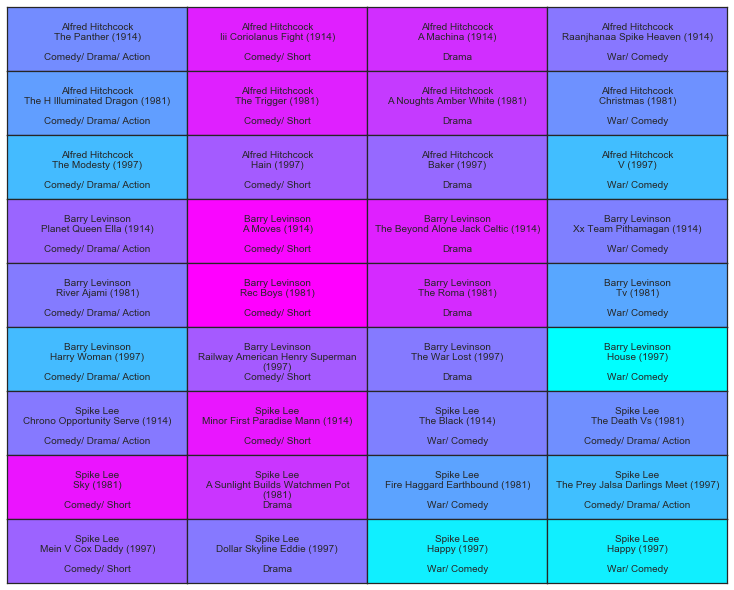

In [22]:

sns.set_style("white")
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(9, 4)
loc = 0
plt.figure(figsize=(10, 8))
alldata['predictedscoreNorm'] = (alldata['predictedscore'] - alldata['predictedscore'].min()) / (alldata['predictedscore'] .max() - alldata['predictedscore'].min())
for k in range(9):
    for j in range(4):
        ax = plt.subplot(gs[k, j])
        ax.text(0,0.8,alldata['Director1'].ix[loc],ha='center', va='top')
        
        ax.text(0,0,alldata['title'].ix[loc],horizontalalignment='center',ha='center', va='top')
        ax.text(0,-1.6,"/ ".join([x for x in alldata[['Genre1','Genre2','Genre3']].ix[loc].values if x != 'None']),horizontalalignment='center', \
                verticalalignment='top')
        
        ax.set_axis_bgcolor(plt.cm.cool(int((alldata['predictedscoreNorm'].ix[loc])*255.)))
        ax.set_ylim([-3,2])
        ax.set_xlim([-3,3])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        loc += 1
        #plt.axis('off')
plt.gcf().canvas.mpl_connect('draw_event', on_draw)
plt.tight_layout(pad=0)
plt.savefig("../docs/resultstest.png")

# Score the Best Result

We now score the "best" result based on a weighted random number. We send that result back to the AWS IoT hub for future machine learning training.

In [14]:
outputdb = bestoption[['title','year','Director1','Genre1','Genre2','Genre3']] 
outputdb["stars"] = str(score)

output = outputdb.to_json()
print(output)

myAWSIoTMQTTClient.publish("filmupdate", output, 1)

{"title":"The Love Night (2007)","year":"2007","Director1":"Howard Hawks","Genre1":"Drama","Genre2":"None","Genre3":"None","stars":"5"}


True